# Scaling Quantum Optimization

In this tutorial we will demonstrate how to implement the **Quantum Approximate Optimization Algorithm (QAOA)** -- a hybrid (quantum-classical) iterative method -- within the context of Qiskit Patterns. For our example, we will solve the **Maximum-Cut** (or **Max-Cut**) problem for a small graph and later demonstrate how to approach on a much larger scale. 


The Max-Cut problem is a hard to solve optimization problem (more specifically it is an *NP-hard* problem) with a number of different applications in clustering, network science, and statistical physics. In it, we consider a graph of nodes connected by vertices which we would like to partition into separate graphs such that they are both as large as possible. Put another way, the goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximum.

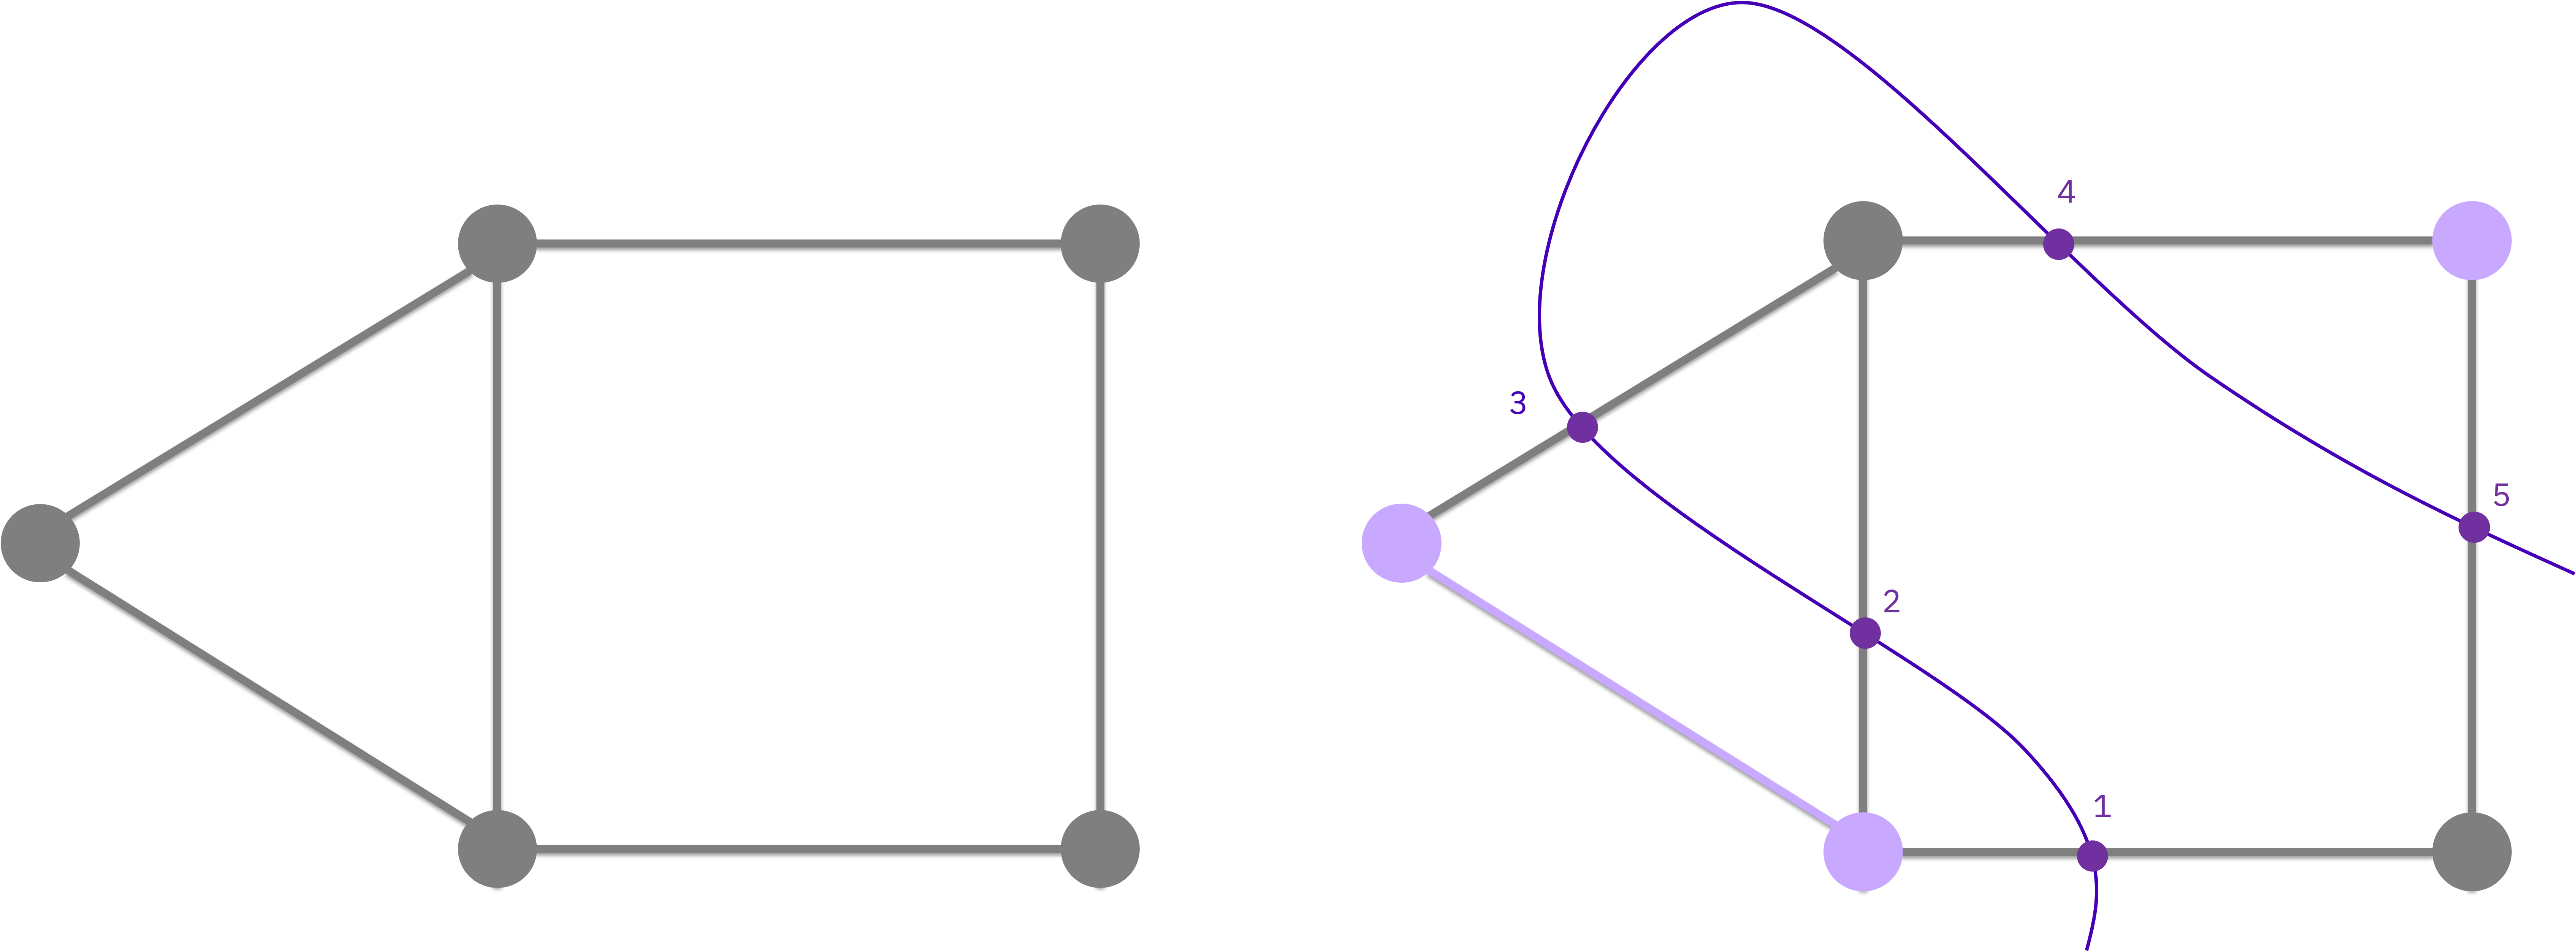

## Part 1: (Small-scale) Qiskit Pattern for Optimization
The first part of this tutorial will use a small-scale Max-Cut problem to ilustrate the steps required to solve an optimization problem using a quantum computer.

First, before considering how to map this problem to a quantum algorithm, let's build some context on how the Max-Cut problem becomes a classical combinatorial optimization problem. We begin by first considering the minimization of a function $f(x)$

\begin{align}
\min_{x\in \{0, 1\}^n}f(x)
\end{align}

where the input $x$ is a vector whose components correspond to each node of a graph.  We then constrain each of these components to be either $0$ or $1$ (i.e. included or not included in the cut). In this first small-scale example case, we set consider a graph with $n=5$ nodes.

We could write a function of a pair of nodes $i,j$ which tells us whether the corresponding edge $(i,j)$ is in the cut. For example, the function $x_i + x_j - 2 x_i x_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

\begin{align}
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j
\end{align}

Which can be rewritten as a minimization of the form

\begin{align}
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j
\end{align}

The minimum of $f(x)$ in this case will be when the number of edges traversed by the cut are maximal. As you can see, there is nothing relating to quantum computing yet. We need to reformulate this problem into something that a quantum computer can understand.


We'll initialize our problem by creating a graph with $n=5$ nodes.

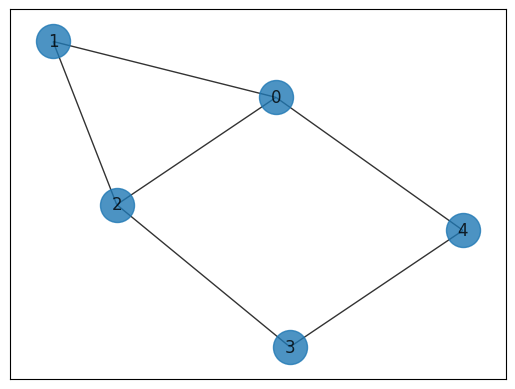

In [33]:
import networkx as nx
import numpy as np

# Generating a graph of 5 nodes
n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

nx.draw_networkx(G, node_size=600, alpha=0.8)

## Step 1. Map the classical inputs to a quantum problem

The first step of the pattern is to map our classical problem (graph) into quantum **circuits** and **operators**.  To do this, we take advantage of a series of mathematical reformulations, such as the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.


<div class="alert alert-block alert-info">
In the QAOA methodology, we ultimately want to have an operator (<b>Hamiltonian</b>) that will be used to represent the <b>cost function</b> of our hybrid algorithm, as well as a parametrized circuit (<b>Ansatz</b>) that we use to represent quantum states with candidate solutions to the problem. We can sample from these candidate states and then evaluate them using the cost function.
</div>

### Graph &rarr; Optimization problem

The first step of the mapping is a notation change, we can express our problem in Quadratic Unconstrained Binary Optimization notation:

\begin{align}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align}

where $Q$ is a $n\times n$ matrix of real numbers, $n$ corresponds to number of nodes in our graph, and $x$ is the vector of binary variables introduced above.

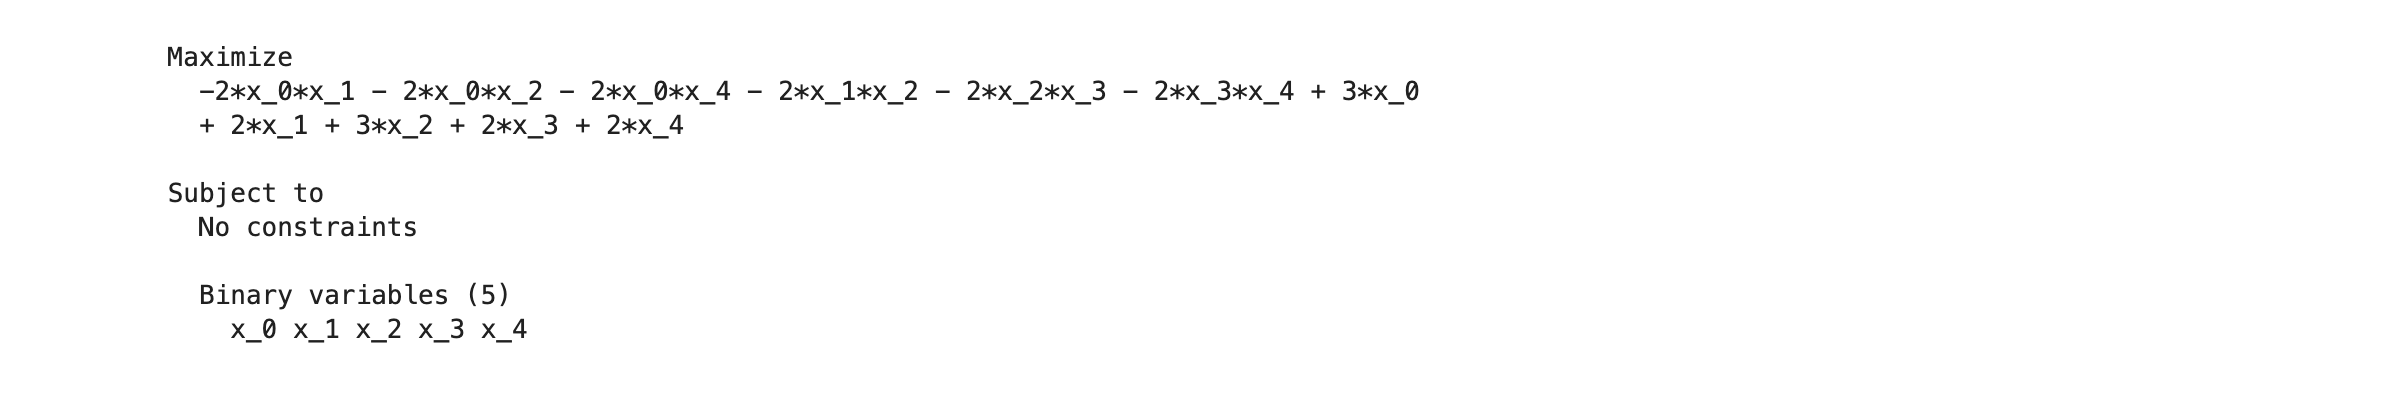

### Optimization problem &rarr; Hamiltonian

We can then reformulate the QUBO notation to express the problem as a **Hamiltonian** (a function that represents the energy of a system):

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

First, a variable change, we convert the binary variables $x_i$ to variables $z_i\in\{-1, 1\}$ by doing

\begin{align}
x_i = \frac{1-z_i}{2}.
\end{align}

Here, for example, we see that if $x_i$ is $0$ then $z_i$ is $1$. When we substitute the $x_i$'s for the $z_i$'s in the optimization problem above, we obtain the equivalent formulations for our optimization task (the details of the computation are shown in Appendix A below):

\begin{align}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

Now, to obtain a quantum formulation of the problem, we promote the $z_i$ variables to a Pauli $Z$ matrix, i.e., a $2\times 2$ matrix of the form

\begin{align}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align}

When we substitute these matrices in the optimization problem above we obtain the following Hamiltonian

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}


We refer to this Hamiltonian as the <b>cost function Hamiltonian</b>. It has the property that its gound state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve our optimization problem we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.


In [34]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: nx.Graph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in graph.edges():
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1]).get("weight", 1.0)

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(G)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### Hamiltonian &rarr; Quantum Circuit

The Hamiltonian $H_c$ contains the quantum definition of our problem. We will now create a quantum circuit that will help us *sample* good solutions form the quantum computer. The QAOA is inspired from quantum annealing and proceeds by applying alternating layers of operators in the quantum cirucit.


Losely speaking, the idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that we are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. 

    
The quantum circuit that we generate is **parametrized** by $\gamma_i$ and $\beta_i$ , so we can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

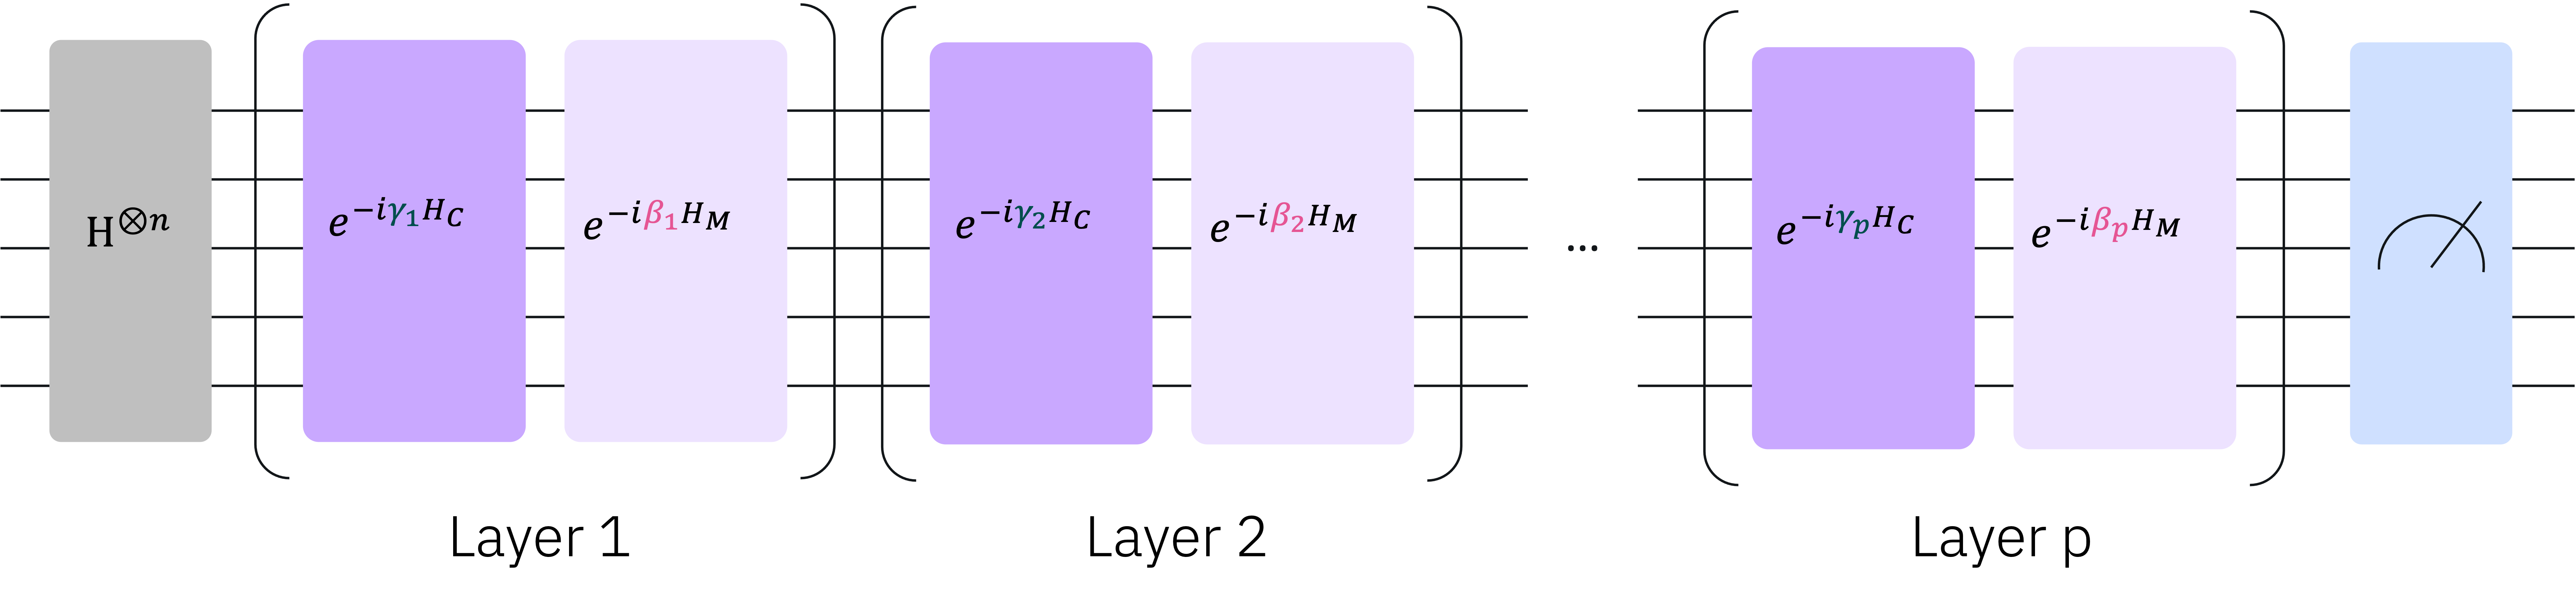


In this case we will try an example with 1 QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.



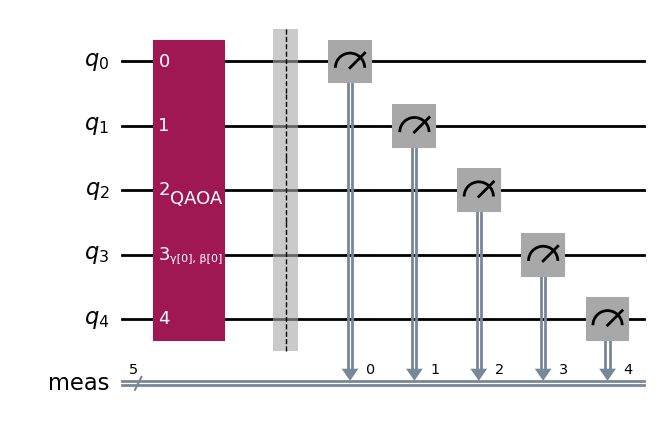

In [35]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()

circuit.draw('mpl')

In [36]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

## Step 2. Optimize problem for quantum execution

The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run in the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. We don't only want to get a circuit, but we want to make sure that the circuit is **optimized** for our purpose. 

Transpilation may involves several steps, such as:

<div class="alert alert-block alert-info">
    <ul>
      <li><b>Intial mapping</b> of the qubits in the circuit (i.e. decision variables) to physical qubits on the device.</li>
      <li><b>Unrolling</b> of the instructions in the quantum circuit to the hardware native instructions that the backend understands.</li>
      <li><b>Routing</b> of any qubits in the circuit that interact to physical qubits that are adjacent with one another.</li>
      <li><b>Error supression</b> by adding single-qubit gates to supress noise with dynamical decoupling.
    </ul> 

</div>

In this example, we have encapsulated a series of transpilation passes in the `optimize_circuit` function. The function takes a circuit and a backend (device) and returns an optimized circuit ready to run in the corresponding device:

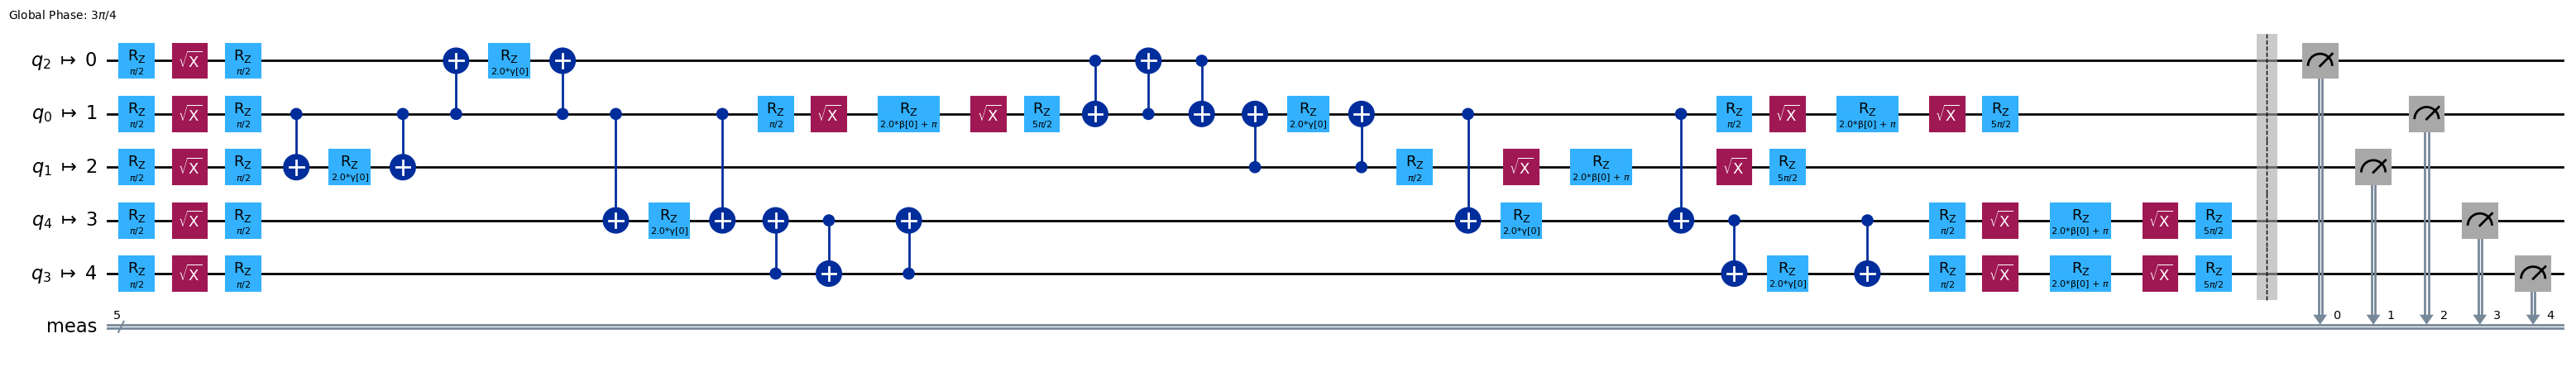

In [37]:
# IBM Quantum devices are named after cities
# For the purpose of the first part of this demo, we will
# use a simulated device from the "fake_provider"
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit import transpile

backend = FakeVigoV2()

candidate_circuit = transpile(circuit, backend)
candidate_circuit.draw('mpl', fold=False)

## Step 3. Execute using Qiskit Runtime primitives

In the general QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, where we run a series of circuit evaluations and use a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. In this demo, we will not optimize these parameters, we will simply assume that someone has done this for us. Note that finding such parameters is a research field in itself.

Once the optimal parameters are defined, we want to perform one final sampling with the resulting circuit to find our candidate solution.

<div class="alert alert-block alert-info">
This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state, for example <code>010101110000...</code> which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).
</div>
    
The execution is done through the **cloud** using the **Qiskit IBM Runtime service**.

### Define circuit with initial parameters

In [38]:
initial_gamma = 3
initial_beta = 8
init_params = [initial_gamma, initial_beta]


### Define backend and execution primitive

To interact with a IBM backends we use the **Qiskit Runtime Primitives**. There are two primitives: Sampler and Estimator, and the choice of primitive depends on the task that we want to run on the quantum computer. We are interested in drawing samples from the quantum computer, so we will use the **Sampler**. 

In [39]:
# For the purpose of the first part of this demo, we will
# use a simulated device from the "fake_provider"
from qiskit_ibm_runtime.fake_provider import FakeVigoV2

backend = FakeVigoV2()

### Run

The primitives offer a variety of execution modes to schedule workloads on quantum devices, a QAOA workflow would be run iteratively in a Session.

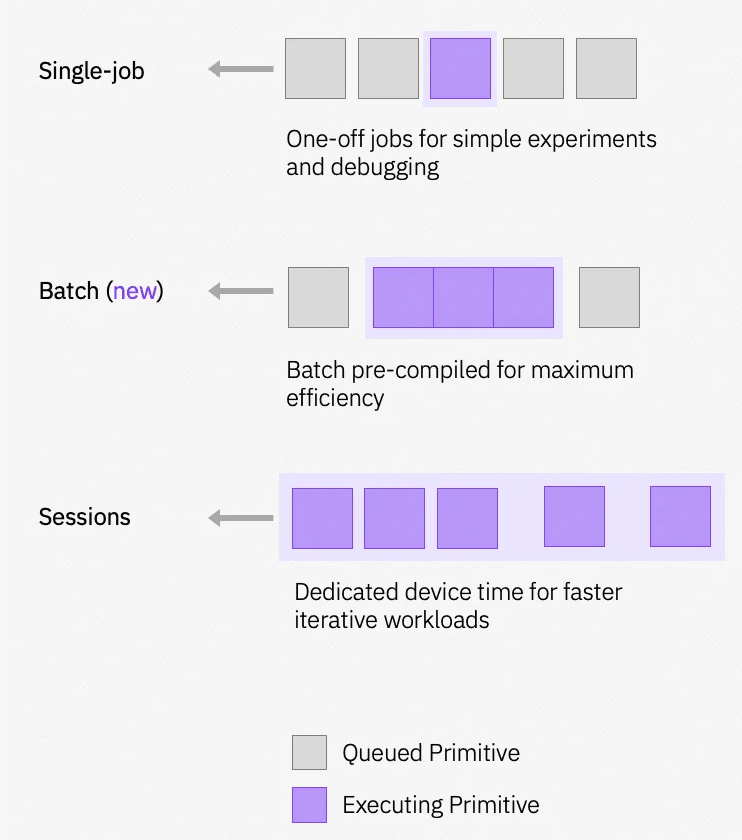

We can plug our sampler-based cost function into the scipy minimizing routine to find our optimal parameters

In [40]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def cost_func_sampler(params, ansatz, hamiltonian, sampler):
    pub = (ansatz, params)
    job = sampler.run([pub])

    counts = job.result()[0].data.meas.get_int_counts()
    shots = sum(counts.values())
    sampled = {key: val/shots for key, val in counts.items()}

    # sampled = sampler_result.quasi_dists[0]
    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, evaluate_sparse_pauli(state, hamiltonian))
        for state, probability in sampled.items()
    }

    result = sum((probability * value).real for probability, value in evaluated.values())

    objective_func_vals.append(result)


    return result

In [41]:
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    sampler = Sampler(backend=backend)
    result = minimize(
        cost_func_sampler,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, sampler),
        method="COBYLA",
    )
    print(result)

/Users/mirko/opt/miniconda3/envs/qaoa/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.728515625
       x: [ 3.530e+00  7.328e+00]
    nfev: 32
   maxcv: 0.0


The optimizer was able to reduce the cost and find better parameters for the circuit

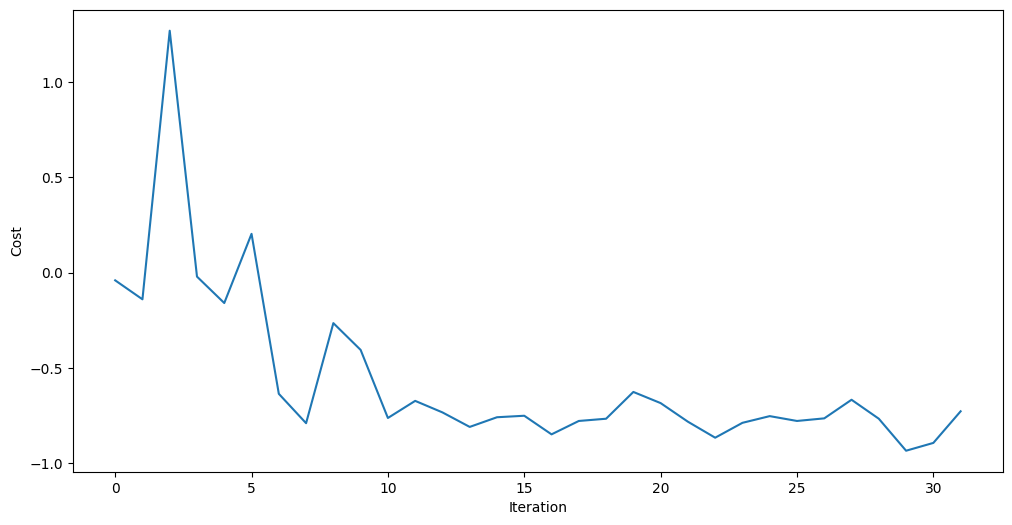

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once we have found the optimal parameters for the circuit, we can assign these parameters and sample the final distribution obtained with the optimized parameters

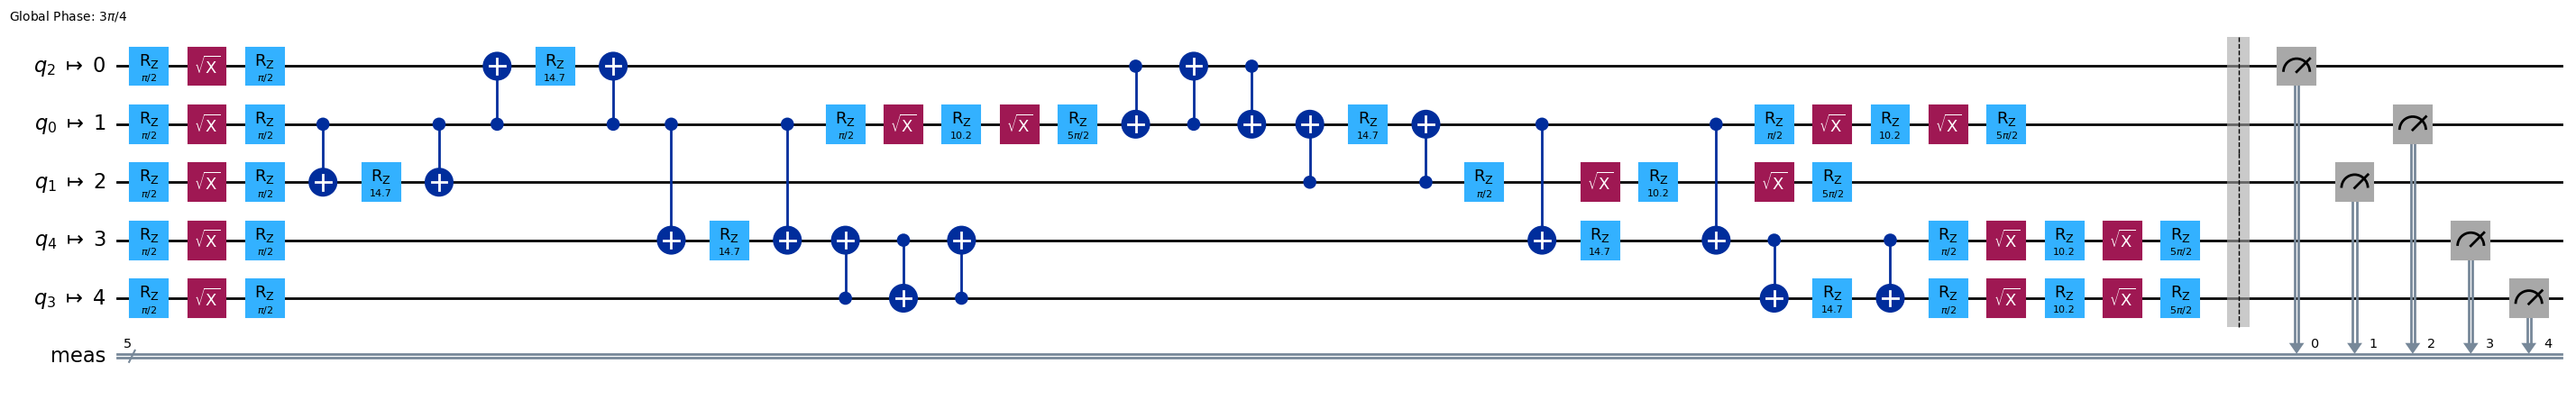

In [43]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False)


In [44]:
with Session(backend=backend) as session:
    sampler = Sampler(backend=backend)
    pub= (optimized_circuit, )
    job = sampler.run([pub], shots=int(1e4))
    counts_int = job.result()[0].data.meas.get_int_counts()
    counts_bin = job.result()[0].data.meas.get_counts()
    shots = sum(counts_int.values())
    final_distribution_int = {key: val/shots for key, val in counts_int.items()}
    final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{10: 0.0813, 16: 0.0363, 13: 0.0715, 8: 0.034, 18: 0.076, 14: 0.0267, 7: 0.0239, 21: 0.0748, 5: 0.0411, 19: 0.0292, 31: 0.0082, 17: 0.0291, 22: 0.0264, 0: 0.0104, 30: 0.0229, 26: 0.0409, 9: 0.0346, 20: 0.0342, 28: 0.0067, 1: 0.0286, 4: 0.0292, 11: 0.034, 23: 0.0272, 27: 0.0244, 29: 0.0165, 12: 0.034, 2: 0.0221, 15: 0.0281, 24: 0.0254, 6: 0.0079, 3: 0.0068, 25: 0.0076}


/Users/mirko/opt/miniconda3/envs/qaoa/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


## Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for our original problem, in this case, we are interested in the bitstring that will determine our optimal cut. The symmetries in the problem allow for 4 possible solutions. The sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that the four of the bitstrings are distictively more likely than the rest.

In [45]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(G))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 0]


/var/folders/dk/j4n5f_1d3xs7m8bq81g9gfk80000gn/T/ipykernel_16269/1639367914.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


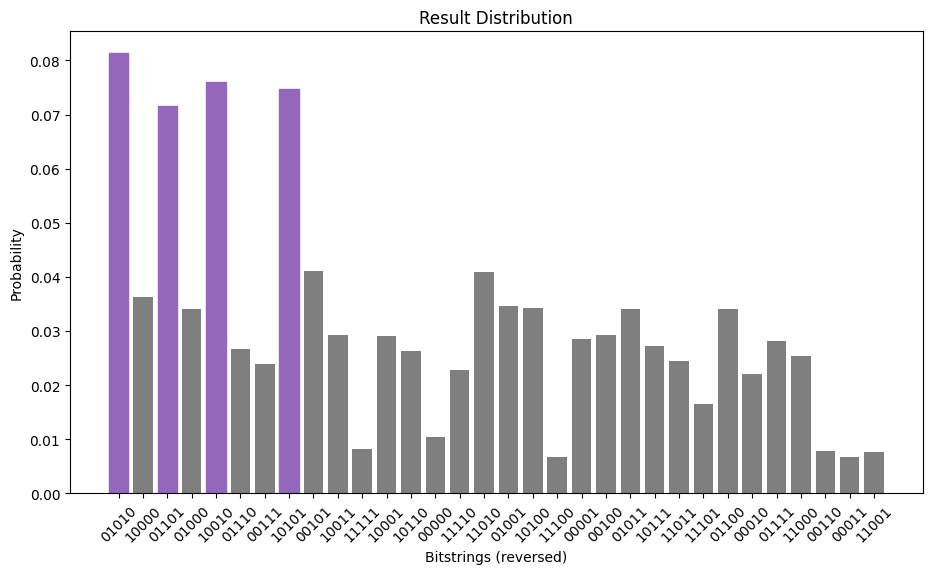

In [46]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()



### Visualize best cut

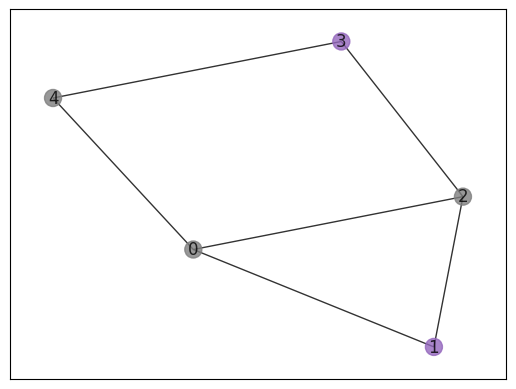

In [47]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=150, alpha=0.8, pos=pos)


plot_result(G, most_likely_bitstring)

---

# Part 2: Let's scale it up and run!

You have access to many 100+ qubits device on the IBM Quantum Platform. Let's select one to run  a large scale problem!

<div class="alert alert-block alert-success">
<b>Call to Action:</b> fill out the cell below with your IQP token (credentials) to authenticate your account.
</div>

In [48]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)


# Eagle = Osaka
# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(instance='grants/qciss/main')


backend = service.get_backend('ibm_pinguino1')

# # Heron = Torino
# backend = service.get_backend('ibm_torino')


Let's try to solve Max-Cut on a 100-node weighted graph, with both positive (green) and negative (red) weights following the 4 steps laid out in part 1. This is a "utility-scale" problem.


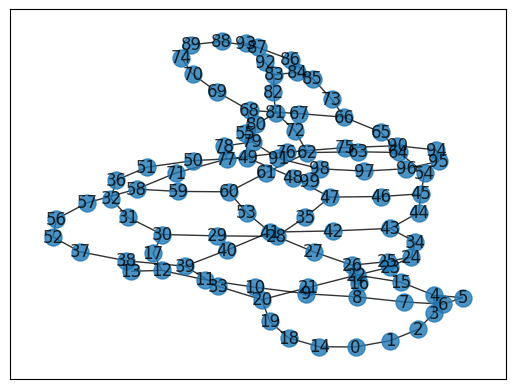

In [49]:
import networkx as nx
import numpy as np

# Generating a graph of 5 nodes
n = 100  # Number of nodes in graph
G_100 = nx.Graph()
G_100.add_nodes_from(np.arange(0, n, 1))
elist = []
used_qubits = set()
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))

G_100.add_weighted_edges_from(elist)

nx.draw_networkx(G_100, node_size=150, alpha=0.8)

## Step 1. Map the classical inputs to a quantum problem

### Graph &rarr; Hamiltonian
Let's convert the graph that we want to solve directly into a Hamiltonian that is suited for QAOA


In [50]:
max_cut_paulis_100 = build_max_cut_paulis(G_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIII

### Hamiltonian &rarr; Quantum Circuit


<div class="alert alert-block alert-info">
    To scale the circuit building step to utility-scale problems, we take advantage of high-level <b>transpilation</b> strategies for remapping and optimizing our QAOA layers during step 1.
</div>

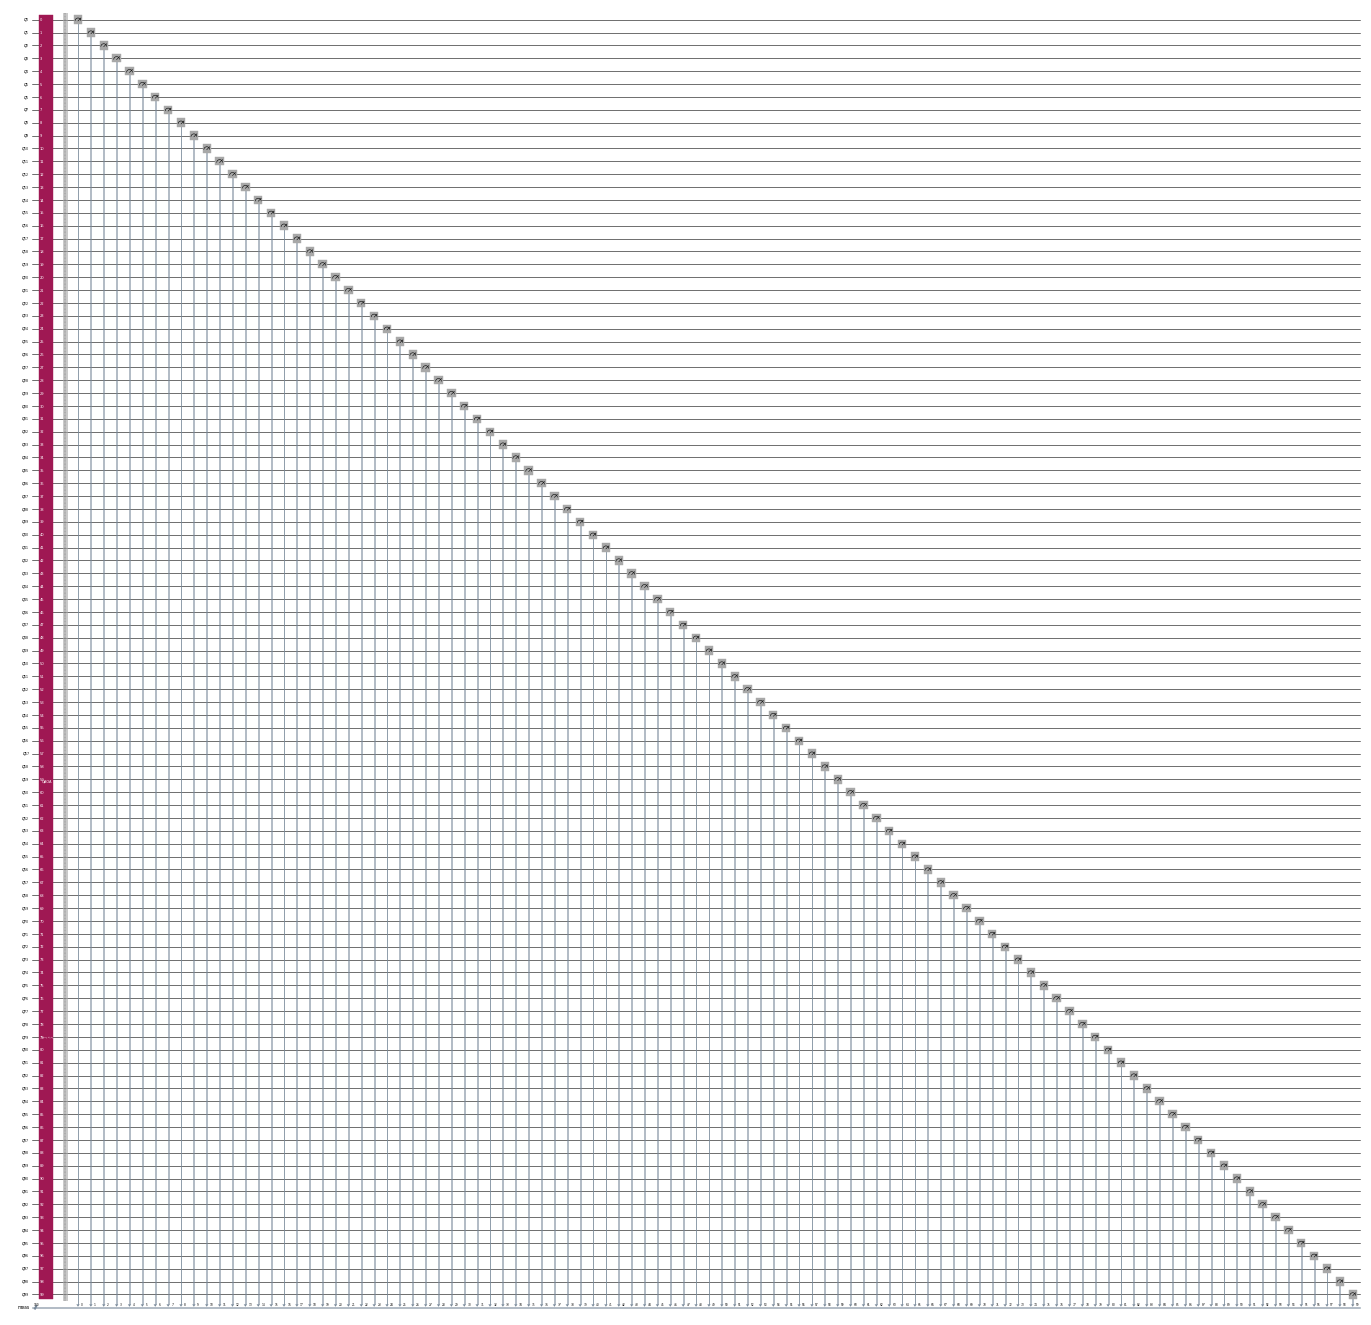

In [51]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2)

## Step 2. Optimize problem for quantum execution

<div class="alert alert-block alert-info">
    To scale the circuit optimization step to utility-scale problems, you can take advantage of the high performance transpilation strategies introduced in Qiskit 1.0. Other tools include the new transpiler service with AI Transpiler passes.
</div>



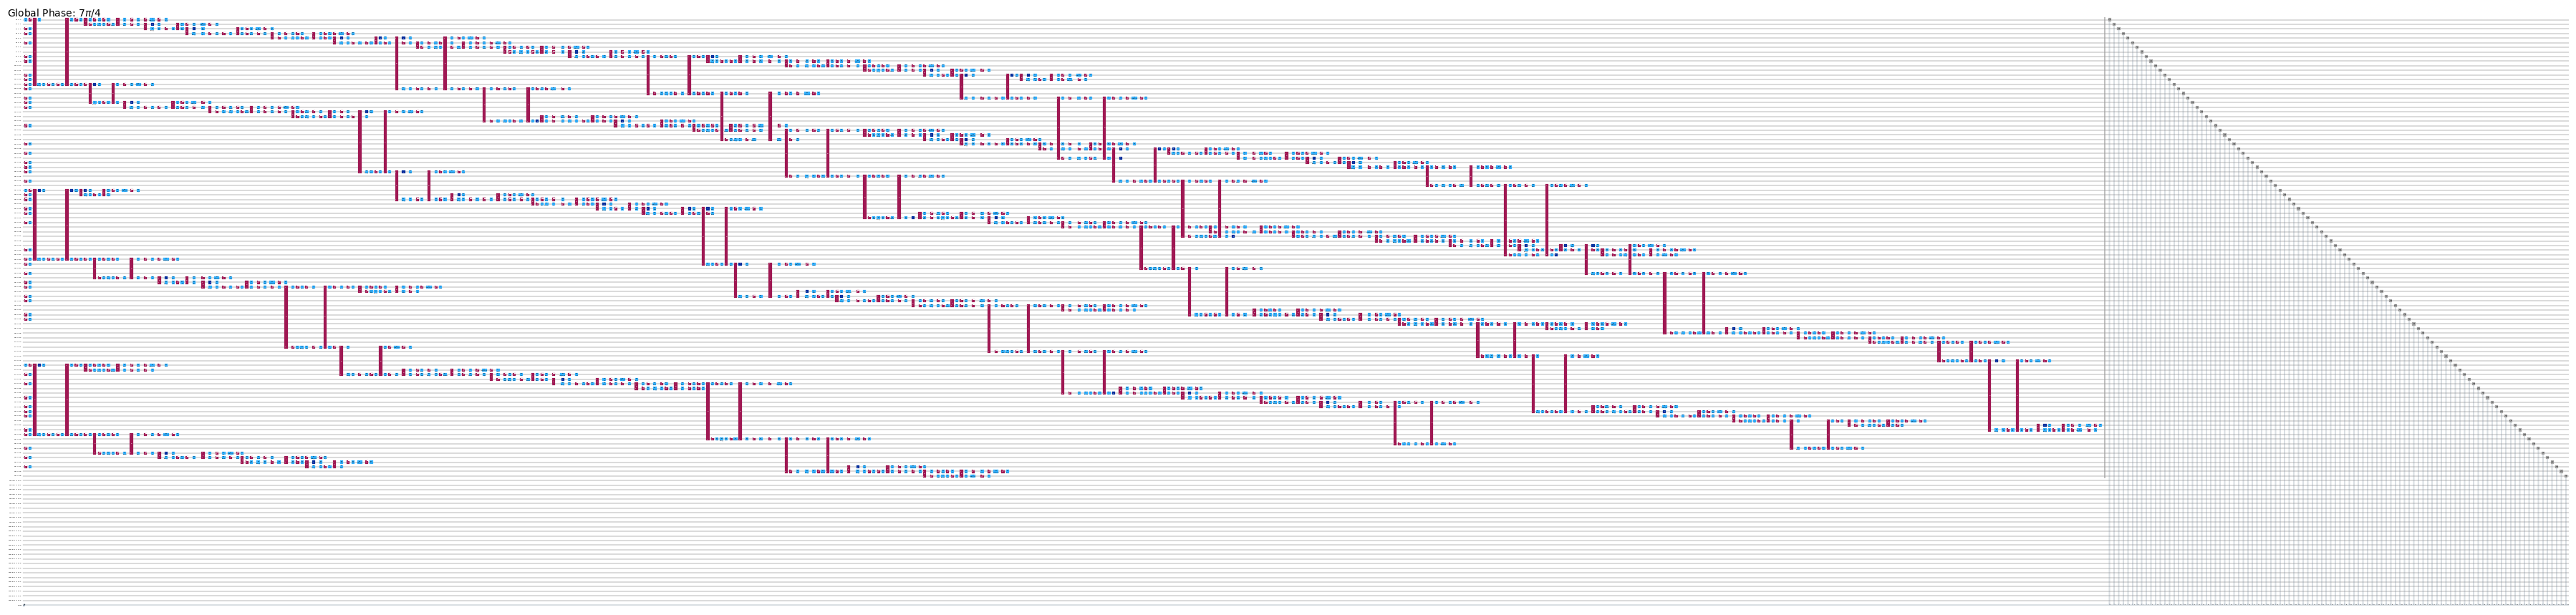

In [52]:
candidate_circuit_100 = transpile(circuit_100, backend, optimization_level=3)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1)

## Step 3. Execute using Qiskit Runtime Primitives

To run QAOA we need to know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit.We will optimize these parameters by running an optimization loop on the device. The cell will submit jobs until the cost function value has converged the optimal parameters for $\gamma_k$ and $\beta_k$ are determined.

### Find candidate solution by running the optimization on the device

Uncomment the following cell to run the circuit on a device, otherwise skip to the next section to load saved data

In [53]:
# initial_gamma = 3
# initial_beta = 5
# init_params = [initial_gamma, initial_beta]

# objective_func_vals = [] # Global variable
# with Session(backend=eagle_backend) as session:
#     sampler = Sampler(session=session)
#     result = minimize(
#         cost_func_sampler,
#         init_params,
#         args=(candidate_circuit_100, cost_hamiltonian_100, sampler),
#         method="COBYLA",
#     )
#     print(result)

In [54]:
# optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
# optimized_circuit_100.draw('mpl', fold=False)

In [55]:

        

# sampler = Sampler(backend=eagle_backend)
# pub= (optimized_circuit_100, )
# job = sampler.run([pub], shots=int(1e4))

# counts_int = job.result()[0].data.meas.get_int_counts()
# counts_bin = job.result()[0].data.meas.get_counts()
# shots = sum(counts_int.values())
# final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}



Now, we will locally save the samples that the backend returned so that we can share them and later analyze them.

In [56]:
# from uuid import uuid4
# import json


# # auxiliary function to save result data
# def save_result(optimized_params, cost_vals, final_distribution, backend_type, path="data/sampler/"):


#     results_to_save = {
#         "optimized_params": optimized_params.tolist(),
#         "cost_vals": cost_vals,
#         "final_distribution": final_distribution,
#     }

#     with open(f"{path}/qaoa_{backend_type}_{str(uuid4())[0:8]}.json", "w") as fout:
#         json.dump(results_to_save, fout)

# save_result(result.x, objective_func_vals, final_distribution_100_int, 'eagle')


## Step 4. Post-process, return result in classical format

Let's load the data from the experiment first.


In [57]:
import os
import json
# auxiliary function to load saved samples
def load_data():

    for file in os.listdir("data/sampler/"):
        if file[-4:] == 'json' and file.startswith("qaoa"):
            with open(f"data/sampler/{file}", "r") as fin:
                data = json.load(fin)
        
    return data

results = load_data()


We can check that the optimization loop has found parameters for the circuit that minimize the cost

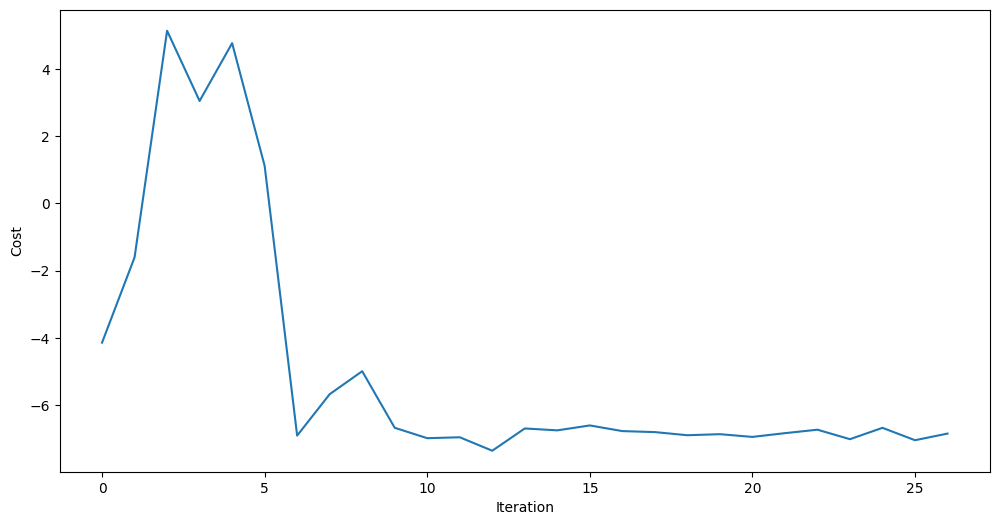

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results['cost_vals'])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Given that the likelihood of each solution is pretty low, we extract the solution that corresponds to the lowest cost

In [59]:
def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol

best_sol_100 = best_solution(results['final_distribution'], cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(G_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

Result bitstring: [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]


And visualize the cut


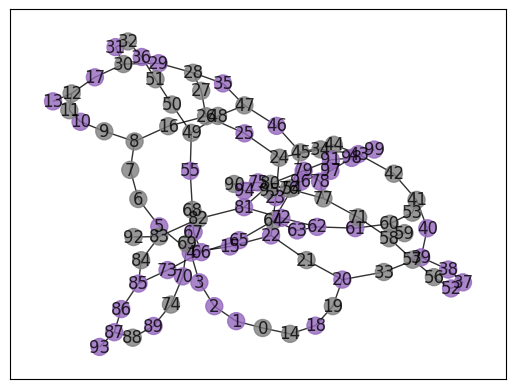

In [60]:
plot_result(G_100, best_sol_bitstring_100)

Now, we need to compute the objective value of each sample that we measured on the quantum computer. The best one will be the solution returned by the quantum computer.

In [61]:
from collections import defaultdict
import matplotlib.pyplot as plt

# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1",)
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [62]:
result_dist = samples_to_objective_values(results['final_distribution'], cost_hamiltonian_100)

Finally, we can plot the cumulative distribution function

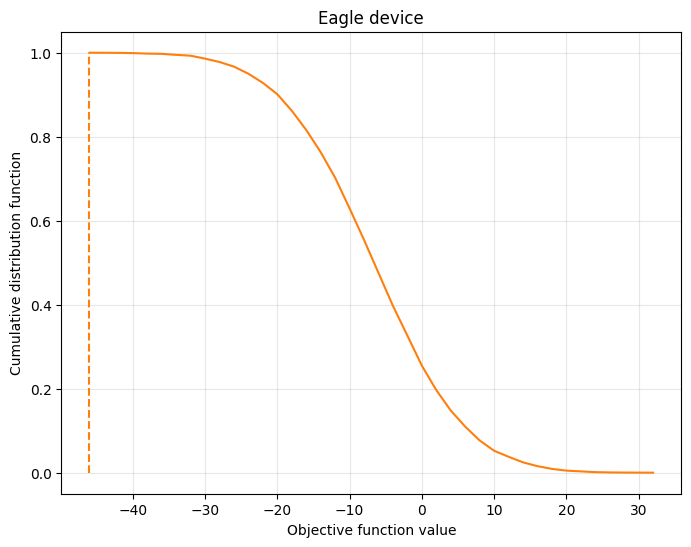

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")

## Conclusion

In this tutorial we present the Qiskit patterns and how to solve an optimization problem with a quantum computer. We demonstrate this at utility-scale, i.e., using on the order of 100 qubits. Currently, quantum computers do not outperform classical computers for combinatorial optimization. They are currently too noisy. However, the hardware is getting better and better and new algorithms for quantum computers are always being developped. This is also where the era of utility will be important. Indeed, much of the research working on quantum heuristics for combinatorial optimization are tested with classical simulations which only allow for a small number of qubits, typically aroud 20 qubits. Now, with larger qubit counts and devices with less noise we will be able to start benchmarking these quantum heuristics at large problem sizes on actual quantum hardware.

-----

## Appendix A: Reformulation in spin variables

Here, we rewrite the Quadratic Unconstrained Binary Optimization problem $x^TQx$ in terms of spin-variables $x_i=(1-z_i)/2$.
\begin{align}
x^TQx=\sum_{ij}Q_{ij}x_ix_j=\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j)=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
\end{align}
If we write $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$ and remove the prefactor and the constant $n^2$ term we arrive at the two equivalent formulations of the same optimization problem
\begin{align}
\max_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \max_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped an irrelevant factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization. 

## Appendix B: Quantum notation

The $Z$ matrices are imbedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ imbedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.